In [1]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
from sklearn import decomposition
from scipy.stats import truncnorm
from collections import Counter
from pprint import pprint
from scipy import linalg
import numpy as np
%matplotlib inline
import matplotlib
import random
import math
import time
import gc

random_seed = 1234
random.seed(random_seed)
plt.rcParams['font.size'] = '12'

In [2]:
## Computing the full singular value decomposition for the MNIST dataset
X, y = fetch_openml(data_id=40996, return_X_y=True)

#Remove mean before applying PCA
X_mean0 = np.array(X - np.mean(X, axis = 0))

U, E, V = np.linalg.svd(X_mean0, full_matrices=False)
E2 = np.array([pow(e,2) for e in E]) # Computing the powers of 2
E3 = E2/np.sum(E2) # Computing the Factor score ratios

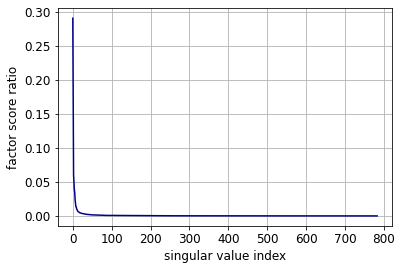

In [3]:
#### Distribution of the factor score ratios
plt.plot(E3, color="darkblue")
plt.grid()
plt.xlabel("singular value index")
plt.ylabel("factor score ratio")
plt.savefig('Fashion_MNIST_sv_distribution.pdf', bbox_inches='tight')

In [4]:
class QuantumState(object):
	"""This class simulates a simple Quantum Register"""
	def __init__(self, registers, amplitudes):
		super(QuantumState, self).__init__()
		self.registers = registers

		#Amplitudes must be normalized to have the right probabilities for each register
		self.norm_factor = math.sqrt(sum([pow(x, 2) for x in amplitudes]))
		self.amplitudes = [x/self.norm_factor for x in amplitudes]
		
		#Each register_i appears with probability amplitude_i^2
		self.probabilities = [pow(x, 2) for x in self.amplitudes]
		assert (len(self.registers) == len(self.amplitudes))
		assert (abs(sum(self.probabilities) - 1) < 0.0000000001)

	def measure(self, n_times=1):
		return random.choices(self.registers, weights=self.probabilities, k=n_times)

	def get_state(self):
		return {self.registers[i]:self.probabilities[i] for i in range(len(self.registers))}

def estimate_wald(measurements):
	counter=Counter(measurements)
	estimate={x:counter[x]/len(measurements) for x in counter}
	return estimate

## Introduce +-epsilon error in a value
def introduce_error(value, epsilon):
    return value + truncnorm.rvs(-epsilon,epsilon, size=1)

def coupon_collect(quantum_state):
    counter = 0
    collection_dict = {value:0 for value in quantum_state.get_state().keys()}

    # Until you don't collect all the values, keep sampling and increment the counter
    while sum(collection_dict.values()) != len(collection_dict):
        value = quantum_state.measure()[0]
        if not collection_dict[value]:
            collection_dict[value] = 1
        counter += 1
    return counter

In [5]:
#### Perform the sampling of the singular values to establish retained variance > 0.85
measurements = 1000 # 1/gamma
q_state = QuantumState(registers=E, amplitudes=E)
estimations  = estimate_wald(q_state.measure(measurements))

exp_var = 0
i = 0
sv = sorted(estimations.keys())
while exp_var <= 0.85:
    exp_var += estimations[sv[-i]]
    i += 1
k = i

real_ext_exp_var = 0
for i in range(k):
    real_ext_exp_var += E3[i]

real_exp_var = 0
i=0
while real_exp_var <= 0.85:
    real_exp_var += E3[i]
    i += 1
real_k = i

print(f"gamma: {math.sqrt(1/measurements)}")
print(f"1/gamma : 1000")
print(f"Estimated k \t- Estimated factor score ratios sum:\t\t{k}, {exp_var}")
print(f"Estimated k \t- Real factor score ratios sum:\t\t\t{k}, {real_ext_exp_var}")
print(f"Real k \t\t- Real factor score ratios sum:\t\t\t{real_k}, {real_exp_var}")

gamma: 0.03162277660168379
1/gamma : 1000
Estimated k 	- Estimated factor score ratios sum:		45, 0.8510000000000003
Estimated k 	- Real factor score ratios sum:			45, 0.8543725984691466
Real k 		- Real factor score ratios sum:			43, 0.8507941476827812


In [6]:
#### Save plots of distribution of components - top-k right singular vectors
Vs = np.sort(np.abs(V.T),axis=0)[::-1] # sort columns (abs components of singular vectors) in descending order
for i in range(k):
    fig = plt.figure()
    plt.plot(Vs[:,i])
    plt.xlabel("component")
    plt.ylabel("absolute magnitude")
    plt.savefig(f"./rightvectors/Fashion_MNIST_rightSV_{i}.pdf", bbox_inches='tight')
    fig.clf()
    plt.close(fig)
    gc.collect()

In [7]:
#### Save plots of distribution of components - top-k left singular vectors
Us = np.sort(np.abs(U),axis=0)[::-1] # sort columns (abs components of singular vectors) in descending order
for i in range(k):
    fig = plt.figure()
    plt.plot(Us[:,i])
    plt.xlabel("component")
    plt.ylabel("absolute magnitude")
    plt.savefig(f"./leftvectors/Fashion_MNIST_leftSV_{i}.pdf", bbox_inches='tight')
    fig.clf()
    plt.close(fig)
    gc.collect()

In [8]:
#### Compute epsilon for the low rank A with k=62
#### epsilon have to be smaller than the smallest gap between (normalized) singular values
NE = E/E[0]

eps = 100
index = 0
for i in range(k):
    if NE[i] - NE[i+1] < eps:
        eps = NE[i] - NE[i+1]
        index = i
        
print(f"Smallest gap between singular values {index}-{index+1}")
print(f"Epsilon to keep right order < {eps}")
print(f"Epsilon to apply threshold < {NE[k-1]-NE[k]}")

Smallest gap between singular values 31-32
Epsilon to keep right order < 0.00038370124990193266
Epsilon to apply threshold < 0.0009046065953983995


In [9]:
#### Computing other run-time parameters for matrix A
A = X_mean0/E[0]

print(f"Frobenius norm for A = {np.linalg.norm(A)}")
print(f"Theta = {NE[k-1]}")

Frobenius norm for A = 1.8551458029927772
Theta = 0.07763501799779342


In [10]:
#### Verify coupon collector for several epsilons
q_state = QuantumState(registers=NE[:k], amplitudes=NE[:k])

epsilons = [0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
n_trials = 1000

avg_points = []
for e in epsilons:
    sve_singular_values = [introduce_error(singular_value, e) for singular_value in NE[:k]]
    amplitudes = [NE[i]/sve_singular_values[i] for i in range(0,k)]
    registers = [index for index in range(0,len(amplitudes))]

    quantum_state = QuantumState(registers,amplitudes)
    avg_points.append(np.average([coupon_collect(quantum_state) for x in range(n_trials)]))

expected_points = [k*math.log(k,2.4) for i in range(len(epsilons))]

print(f"Results computed on number of measurements: {n_trials}" )
print(f"Epsilons: {epsilons}")
print(f"Expected measurements: {expected_points[0]}")
print(f"Experiment measurements: {avg_points}")

Results computed on number of measurements: 1000
Epsilons: [0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
Expected measurements: 195.66639530432263
Experiment measurements: [199.762, 199.49, 197.707, 199.15, 203.28, 219.727, 232.513, 273.15, 350.039, 332.052, 586.524, 725.475, 1406.915, 4833.047]


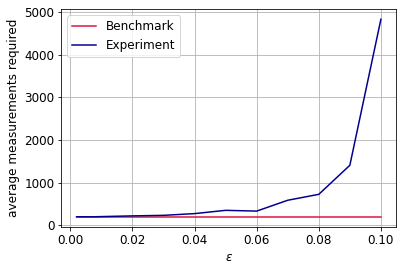

In [11]:
#### Plot coupon collector
plt.plot(epsilons,expected_points, color="crimson", label='Benchmark')
plt.plot(epsilons,avg_points, color="darkblue", label='Experiment')

plt.grid()
plt.legend(loc=2)
plt.xlabel(r"$\epsilon$")
plt.ylabel("average measurements required")
plt.savefig(f'Fashion_MNIST_Coupon_Collect{k}.pdf', bbox_inches='tight')

In [12]:
#Given a vector it makes it noisy by adding gaussian error to each component
def make_noisy_vec(vec, noise):
    noise_per_component = noise/np.sqrt(len(vec))
    errors = truncnorm.rvs(-noise_per_component,noise_per_component, size=len(vec))
    new_vec = np.array([vec[i] + errors[i] for i in range(len(vec))])
    return new_vec

#Given a matrix it makes it noisy by adding gaussian error to each component
def make_noisy_mat(A, noise):
    vector_A = A.reshape(A.shape[0]*A.shape[1])
    vector_B = make_noisy_vec(vector_A, noise)
    B = vector_B.reshape(A.shape[0],A.shape[1])
    return B

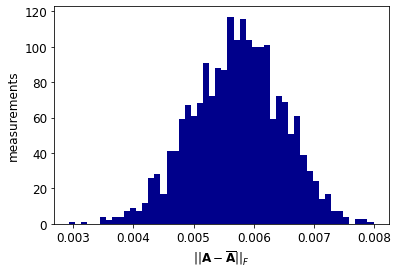

In [13]:
## Check the distribution of the noisy function over 2000 samples
#Create the original vector
A = np.array([[3,4,2],
     [5,6,6],
     [9,4,7],
     [1,0,8]])

#Specify max noise in the Frobenius norm
total_error = 0.01
samples = []
for i in range(2000):
    #Create a noisy copy
    B = make_noisy_mat(A, total_error)
    #Append the Frobenius norm of A-B to the samples
    samples.append(np.linalg.norm(A-B))

#Plot the samples
plt.hist(samples, bins=50, color="darkblue")
plt.xlabel(r"$||\mathbf{A} - \overline{\mathbf{A}}||_F$")
plt.ylabel("measurements")
plt.savefig('error_matrix_frobenious.pdf', bbox_inches='tight')

In [14]:
#### Perform again PCA on the dataset to test for classification error. Use only the first k components

#Fit PCA
pca = decomposition.PCA(svd_solver="full")
pca.n_components = k
pca_model = pca.fit(X_mean0)

#Transform the features
X_train_pca = pca_model.transform(X_mean0)
#Scale the matrix with the spectral norm
X_train_pca_scaled = X_train_pca/pca_model.singular_values_[0] # check Claim in PCA section, it's ok if we normalize here

In [15]:
#### Perform knn with k=7 on the exact matrix UE
start = time.time()
knn = KNeighborsClassifier(n_neighbors=7)
score = cross_validate(knn,X_train_pca_scaled,y,cv=StratifiedKFold(n_splits=10,shuffle=True, random_state=random_seed), n_jobs=4)
end = time.time()
tot_time = end-start
accuracy = np.average(score['test_score'])

print(f"10-fold Cross-validation - Real UE")
print(f"Tot time: {tot_time}")
print(f"Accuracy: {accuracy}")

10-fold Cross-validation - Real UE
Tot time: 68.12641787528992
Accuracy: 0.8617285714285714


In [ ]:
#### Perform knn with k=7 on the estimated matrix UE, with different errors
start = time.time()
accuracies = []
k_sqrt = np.sqrt(pca.n_components)
eps_delta = [0.8, 0.6, 0.4, 0.2, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.0008]
errors= [k_sqrt*error for error in eps_delta]
for error in errors:
    B = make_noisy_mat(X_train_pca_scaled, error)
    f_norm = np.linalg.norm(X_train_pca_scaled-B)
    score = cross_validate(knn,B,y,cv=StratifiedKFold(n_splits=10,shuffle=True, random_state=random_seed), n_jobs=4)
    accuracies.append([error, f_norm, np.average(score['test_score'])])
end = time.time()
tot_time = end-start

print(f"10-fold Cross-validation - Estimated UE")
print(f"Tot time: {tot_time}")
print(f"(delta + epsilon): {eps_delta}")
print(f"Error-F_norm-Accuracy: {accuracies}")

In [ ]:
#### plot accuracy with respect to (epsilon+delta) bound
to_plot_x = eps_delta[:]
to_plot_y = [exp[2] for exp in accuracies[:]]

plt.plot(to_plot_x, [accuracy]*len(to_plot_x), color="crimson", label='Benchmark')
plt.plot(to_plot_x, to_plot_y, color="darkblue", label='Experiment')

plt.grid()
plt.legend(loc=3)
plt.xlabel(r"($\epsilon+\delta$)")
plt.ylabel("accuracy")
plt.savefig('Fashion_MNIST_Classification_epsdelta.pdf', bbox_inches='tight')

In [ ]:
#### plot accuracy with respect to full bound
to_plot_x = [exp[0] for exp in accuracies[:]]

plt.plot(to_plot_x, [accuracy]*len(to_plot_x), color="crimson", label='Benchmark')
plt.plot(to_plot_x, to_plot_y, color="darkblue", label='Experiment')

plt.grid()
plt.legend(loc=3)
plt.xlabel(r"$\sqrt{k}(\epsilon+\delta)$")
plt.ylabel("accuracy")
plt.savefig('Fashion_MNIST_Classification_bound.pdf', bbox_inches='tight')

In [ ]:
#### plot accuracy with respect to real Fnorm error
to_plot_x = [exp[1] for exp in accuracies[:]]

plt.plot(to_plot_x, [accuracy]*len(to_plot_x), color="crimson", label='Benchmark')
plt.plot(to_plot_x, to_plot_y, color="darkblue", label='Experiment')

plt.grid()
plt.legend(loc=3)
plt.xlabel(r"$||\mathbf{U}\Sigma - \overline{\mathbf{U}}\overline{\Sigma}||_F$")
plt.ylabel("accuracy")
plt.savefig('Fashion_MNIST_Classification_Fnorm.pdf', bbox_inches='tight')

In [ ]:
#### plot accuracy with respect to the relative Fnorm error
UE_norm = np.linalg.norm(X_train_pca_scaled)
to_plot_x = [tupl[1]/UE_norm for tupl in accuracies[:]]

plt.plot(to_plot_x, [accuracy]*len(to_plot_x), color="crimson", label='Benchmark')
plt.plot(to_plot_x, to_plot_y, color="darkblue", label='Experiment')

plt.grid()
plt.legend(loc=3)
plt.xlabel(r"$(||\mathbf{U}\Sigma - \overline{\mathbf{U}}\overline{\Sigma}||_F)/||\mathbf{U}\Sigma||_F$")
plt.ylabel("accuracy")
plt.savefig('Fashion_MNIST_Classification_Fnorm_relative.pdf', bbox_inches='tight')